<a href="https://colab.research.google.com/github/Vinicius-S-Grilo/Portfolio/blob/main/MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A - Machine Learning**

**Definição do problema**

O dataset escolhido aborda um problema de classificação. Trata-se de uma instituição de ensino superior que deseja avaliar se um aluno irá concluir ou desistir do curso baseado em uma série de atributos como curso, performace academica, fatores socio-econômicos entre outros.

mais informações a respeito do dataset pode ser encontrada em https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

Há três categorias possíveis: *dropout*, *enrolled* e *graduate*

O dataset já foi previamente preprocessado para remoção de missing values e outliers.

In [2]:
#importando as bibliotecas a serem utilizadas
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

**Preparação dos dados**

Como os dados já vieram pre processados, não há necessidade de utilizar técnicas de pre processamento para tratamento de missing values ou remoção de outliers.

Nesta etapa, será feito o carregamento do dataset, separação entre treino/teste, parametrização pra validação cruzada, criação e comparação dos modelos.

In [6]:
#Carregando o dataset
dataset = pd.read_csv(r"/content/MVP/ML/data.csv", sep=';')

In [10]:
#Tratando os dados para treinamento do modelo
#separação dos atributos e da categoria
X = np.array(dataset.iloc[:,:-1].copy())
y = np.array(dataset.iloc[:,-1].copy())

#separação teste/treino
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

#Parâmetros para validação cruzada
n_part = 10
kfold = KFold(n_splits=n_part,shuffle=True, random_state=10)

#Criação e preparação dos modelos e seus resultados
models = []
results = []
names = []

models.append(("KNN",KNeighborsClassifier()))
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(("CART",DecisionTreeClassifier()))
models.append(("NB",GaussianNB()))
models.append(("SVC",SVC()))

for name,model in models:
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)


KNN: 0.5936788783790271 (0.027958817701309913)
LR: 0.6953793953361822 (0.025023645819575304)
CART: 0.6795665882428257 (0.013652455618592196)
NB: 0.6869056193082697 (0.029678089117343605)
SVC: 0.5035194699188554 (0.02250900968881935)


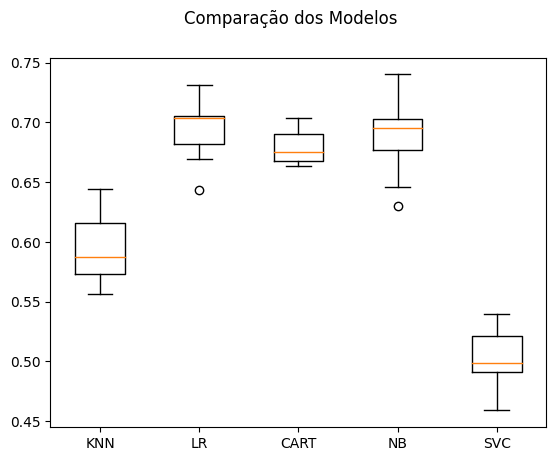

In [11]:
#Boxplot para comparar a precisão dos modelos
fig = plt.figure()
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Com base no plot acima, é possível perceber que o modelo com maior precisão é o de Regressão Logística (LR), seguido do Naive Bayes e da Árvore de Decisão. Como não há diferença estatística significativa entre os três modelos, vou seguir com eles para testar uma abordagem de feature selection e avaliar se a precisão dos modelos melhora.

In [13]:
#Testando a precisão dos modelos com o dado teste

for i in models:
  if i[0] in ["NB","CART","LR"]:
    model = i[1]
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    print(f"Precisão de {i[0]}: {accuracy_score(y_test,predictions):.2%} ")


Precisão de LR: 66.89% 
Precisão de CART: 68.14% 
Precisão de NB: 64.29% 


In [15]:
#Testando feature selection pra otimizar modelo
#números de features a serem escolhidos
n = 10

print("Atributos Originais:\n", dataset.columns[0:36])
print("\n\n##Iniciando os testes com feature selection##\n\n")

#teste ANOVA de Seleção Univariada
best_var = SelectKBest(score_func=f_classif, k=n)

fit = best_var.fit(X,y)

features=fit.transform(X)

#Print dos resultados
print("Resultados do ANOVA - seleção univariada\n")
print(f"Atributos originais: {X.shape[1]}")
print(f"Atributos reduzidos: {features.shape[1]}")

print("Scores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=dataset.columns[0:36]))

red_features_f = best_var.get_feature_names_out(input_features=dataset.columns[0:36])


# Eliminação Recursiva de Atributos

# Criação do modelo
modelo = LogisticRegression(max_iter=200)

# Eliminação Recursiva de Atributos
rfe = RFE(modelo, n_features_to_select=n)
fit = rfe.fit(X, y)

# Print dos resultados

print("\nResultados da Eliminação recursiva de atributos\n")


# Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
# e com valor 1 em "Ranking dos Atributos")
print("\nAtributos Selecionados: %s" % fit.support_)
print("\nRanking de atributos: %s" % fit.ranking_)
print("\nQtd de melhores Atributos: %d" % fit.n_features_)
print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=dataset.columns[0:36]))
red_features_RFE = fit.get_feature_names_out(input_features=dataset.columns[0:36])

# Importância de Atributos com ExtraTrees
# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)


# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print("\nResultados da Importância de atributos com ExtraTrees\n")
print(modelo.feature_importances_)
ipt=modelo.feature_importances_
red_features_ExT = dataset.columns[0:36][ipt.argsort()[-n:]]









Atributos Originais: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       

In [ ]:
#Mostrando os top 10 atributos selcionados de acordo com as técnicas de feature selection
print("ANOVA - ")